## Flight fare prediction - ms

In [129]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

pd.set_option("display.max_columns",None)

## Importing dataset

1. Since data is in form of excel file we have to use pandas read_excel to load the data
2. After loading it is important to check the complete information of data as it can indication many of the hidden infomation such as null values in a column or a row
3. Check whether any null values are there or not. if it is present then following can be done,
    1. Imputing data using Imputation method in sklearn
    2. Filling NaN values with mean, median and mode using fillna() method
4. Describe data --> which can give statistical analysis

In [130]:
train_data = pd.read_excel(r"Data_Train.xlsx")
train_data.shape
train_data.columns
train_data.head()

(10683, 11)

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [9]:
train_data.isnull().sum() # just 2 null values, can remove them

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [131]:
train_data.dropna(inplace=True)
train_data.shape
train_data.isnull().sum() # just 1 row dropped

(10682, 11)

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [18]:
train_data.describe()

,Price
count,10682.000000
mean,9087.214567
std,4611.548810
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [19]:
train_data.describe(include ='object')

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
count,10682,10682,10682,10682,10682,10682,10682,10682,10682,10682
unique,12,44,5,6,128,222,1343,368,5,10
top,Jet Airways,18/05/2019,Delhi,Cochin,DEL → BOM → COK,18:55,19:00,2h 50m,1 stop,No info
freq,3849,504,4536,4536,2376,233,423,550,5625,8344


In [20]:
train_data.nunique()

Airline              12
Date_of_Journey      44
Source                5
Destination           6
Route               128
Dep_Time            222
Arrival_Time       1343
Duration            368
Total_Stops           5
Additional_Info      10
Price              1870
dtype: int64

In [17]:
train_data.Duration.value_counts()

2h 50m     550
1h 30m     386
2h 55m     337
2h 45m     337
2h 35m     329
          ... 
35h 20m      1
40h 20m      1
35h 35m      1
42h 5m       1
29h 40m      1
Name: Duration, Length: 368, dtype: int64

## EDA

From description we can see that Date_of_Journey is a object data type,\
Therefore, we have to convert this datatype into timestamp so as to use this column properly for prediction

For this we require pandas **to_datetime** to convert object data type to datetime dtype.

<span style="color: red;">**.dt.day method will extract only day of that date**</span>\
<span style="color: red;">**.dt.month method will extract only month of that date**</span>

In [132]:
train_data['Journey_day'] = pd.to_datetime(train_data.Date_of_Journey, format="%d/%m/%Y").dt.day
train_data['Journey_month']= pd.to_datetime(train_data.Date_of_Journey, format="%d/%m/%Y").dt.month
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


In [133]:
# Since we have converted Date_of_Journey column into integers, Now we can drop as it
train_data.drop("Date_of_Journey", axis=1, inplace=True)
train_data.head(3)

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6


In [134]:
# Departure time is when a plane leaves the gate. 
# Similar to Date_of_Journey we can extract values from Dep_Time

# Extracting Hours
train_data['Dep_hour']= pd.to_datetime(train_data.Dep_Time).dt.hour
# Extracting minute
train_data['Dep_min']= pd.to_datetime(train_data.Dep_Time).dt.minute
train_data.drop("Dep_Time", axis=1,inplace=True, )
train_data.head(3)

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,13:15,7h 25m,2 stops,No info,7662,1,5,5,50
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,04:25 10 Jun,19h,2 stops,No info,13882,9,6,9,25


In [135]:
# Arrival time is when the plane pulls up to the gate.
train_data['Arrival_hour']=pd.to_datetime(train_data.Arrival_Time).dt.hour
train_data['Arrival_min'] =pd.to_datetime(train_data.Arrival_Time).dt.minute
train_data.drop("Arrival_Time", axis=1, inplace=True)
train_data.head(3)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25


In [ ]:
# Time taken by plane to reach destination is called Duration
# It is the differnce betwwen Departure Time and Arrival time


# Assigning and converting Duration column into list
duration = list(train_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

In [140]:
# Adding duration_hours and duration_mins list to train_data dataframe
train_data['Duration_hours'] = duration_hours
train_data['Duration_mins'] = duration_mins
train_data.head(3)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25,19,0


In [51]:
'12h 50m'.split()
len('12h 50m'.split())

['12h', '50m']

2

In [47]:
# int('12h 50m'.split(sep="m")[0])
int('12h 50m'.split(sep="m")[0].split()[-1])

50

In [141]:
train_data.drop(['Duration'],axis=1,inplace=True)
train_data.head(3)

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0


## Handling Categorical Data

One can find many ways to handle categorical data. Some of them categorical data are,
1. <span style="color: blue;">**Nominal data**</span> --> data are not in any order --> <span style="color: green;">**OneHotEncoder**</span> is used in this case
2. <span style="color: blue;">**Ordinal data**</span> --> data are in order --> <span style="color: green;">**LabelEncoder**</span> is used in this case

In [142]:
train_data.Airline.value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

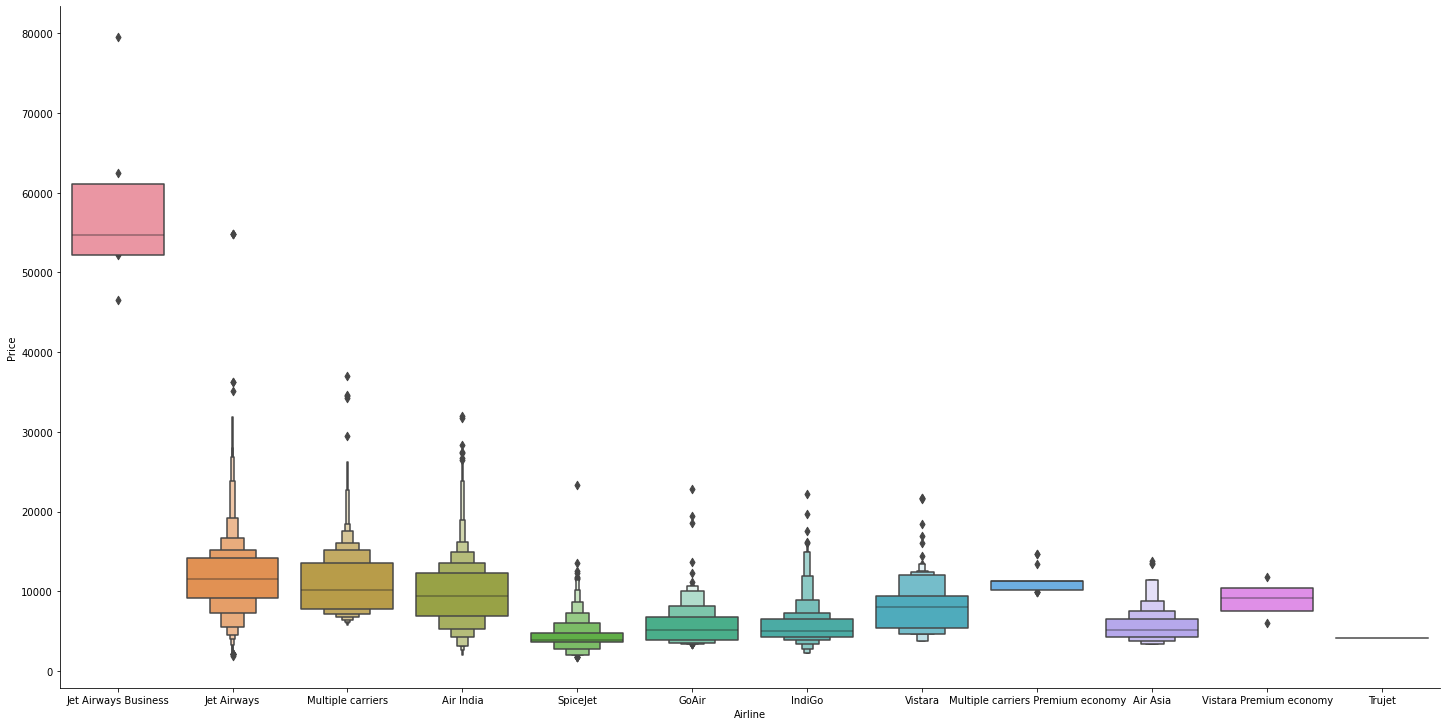

In [153]:
# From graph we can see that Jet Airways Business have the highest Price.
# Apart from the first Airline almost all are having similar median (price)

# Airline vs Price
sns.catplot(y ="Price", x="Airline",data=train_data.sort_values('Price', ascending=False),kind='boxen',height=10, aspect=2);

In [154]:
# As Airline is Nominal Categorical data we will perform OneHotEncoding
Airline = train_data.Airline
Airline = pd.get_dummies(Airline, drop_first=True)
Airline.shape
Airline.head()
train_data.Airline.unique()

(10682, 11)

,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Jet Airways Business',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

In [71]:
train_data.Source.value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

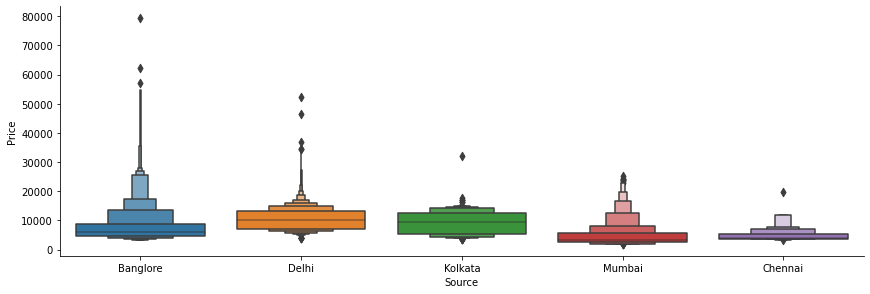

In [72]:
sns.catplot(x='Source',y='Price', data=train_data.sort_values("Price",ascending=False),kind='boxen',height=4, aspect=3);
# Blore outliers more, Delhi-Kolkata are similar, Mumbai-Chennai are similar

In [155]:
Source = train_data.Source
Source = pd.get_dummies(Source, drop_first=True)
Source.shape
train_data.Source.unique()
Source.head(3)

(10682, 4)

array(['Banglore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

,Chennai,Delhi,Kolkata,Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0


In [74]:
train_data.Destination.value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

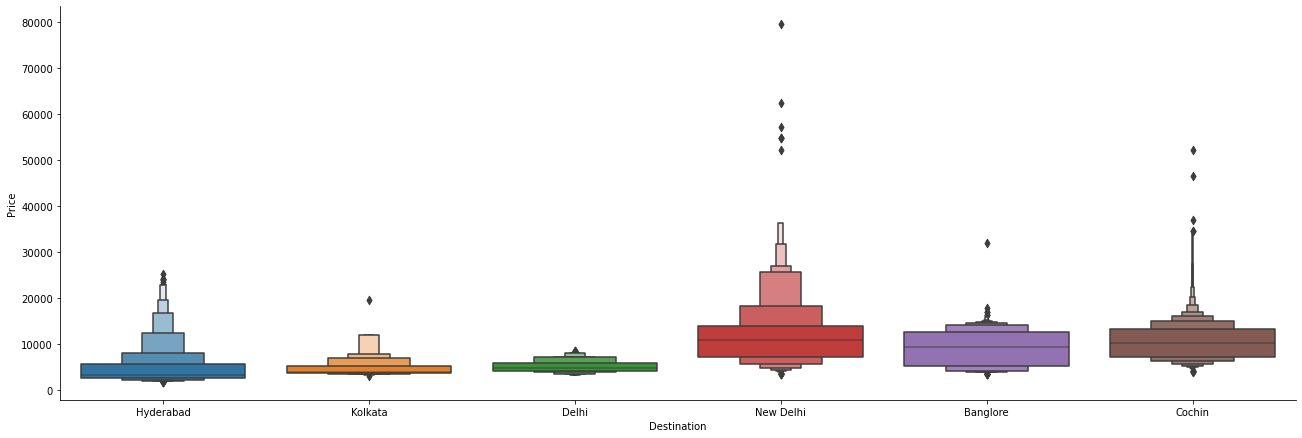

In [77]:
sns.catplot(x='Destination',y='Price',data=train_data.sort_values('Price',ascending=True), kind='boxen',height=6,aspect=3);

In [156]:
Destination = train_data.Destination
Destination = pd.get_dummies(Destination, drop_first=True)
Destination.shape
train_data.Destination.unique()
Destination.head()

(10682, 5)

array(['New Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Delhi', 'Hyderabad'],
      dtype=object)

,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [79]:
train_data.Route

0                    BLR → DEL
1        CCU → IXR → BBI → BLR
2        DEL → LKO → BOM → COK
3              CCU → NAG → BLR
4              BLR → NAG → DEL
                 ...          
10678                CCU → BLR
10679                CCU → BLR
10680                BLR → DEL
10681                BLR → DEL
10682    DEL → GOI → BOM → COK
Name: Route, Length: 10682, dtype: object

In [80]:
train_data.Additional_Info.value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
2 Long layover                     1
1 Short layover                    1
Red-eye flight                     1
Name: Additional_Info, dtype: int64

In [157]:
# Additional_Info contains almost 80% no_info
# Route and Total_Stops are related to each other
train_data.drop(['Route',"Additional_Info"], axis=1, inplace=True)
train_data.head(4)

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,non-stop,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2 stops,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2 stops,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1 stop,6218,12,5,18,5,23,30,5,25


In [83]:
train_data.Total_Stops.value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [158]:
# As this is case of Ordinal Categorical type we perform LabelEncoder
# Here Values are assigned with corresponding keys
train_data.replace({'non-stop':0,"1 stop":1, "2 stops":2, "3 stops":3, "4 stops":4}, inplace=True)
train_data.head(3)

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0


In [159]:
# Concatenate dataframe --> train_data + Airline + Source + Destination
data_train = pd.concat([train_data,Airline, Source,Destination ], axis=1)
data_train.head(3)

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [160]:
data_train.drop(['Airline','Source','Destination'], axis=1, inplace=True)
data_train.head(3)

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [94]:
data_train.shape

(10682, 30)

## TEST data

In [161]:
test_data = pd.read_excel(r"Test_set.xlsx")
test_data.shape
test_data.columns
test_data.head()

(2671, 10)

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info'],
      dtype='object')

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [170]:
# Preprocessing

print("Test data Info")
print("-"*100)
print(test_data.info())

print()
print()

print("Null values before")
print("-"*100)
test_data.isnull().sum()
print("Null values :")
print("-"*100)
test_data.dropna(inplace = True)
print(test_data.isnull().sum())

print()
print()

# EDA

# Date_of_Journey
test_data["Journey_day"] = pd.to_datetime(test_data.Date_of_Journey, format="%d/%m/%Y").dt.day
test_data["Journey_month"] = pd.to_datetime(test_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month
test_data.drop(["Date_of_Journey"], axis = 1, inplace = True)

# Dep_Time
test_data["Dep_hour"] = pd.to_datetime(test_data["Dep_Time"]).dt.hour
test_data["Dep_min"] = pd.to_datetime(test_data["Dep_Time"]).dt.minute
test_data.drop(["Dep_Time"], axis = 1, inplace = True)

# Arrival_Time
test_data["Arrival_hour"] = pd.to_datetime(test_data.Arrival_Time).dt.hour
test_data["Arrival_min"] = pd.to_datetime(test_data.Arrival_Time).dt.minute
test_data.drop(["Arrival_Time"], axis = 1, inplace = True)

# Duration
duration = list(test_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

# Adding Duration column to test set
test_data["Duration_hours"] = duration_hours
test_data["Duration_mins"] = duration_mins
test_data.drop(["Duration"], axis = 1, inplace = True)


# Categorical data

print("Airline")
print("-"*75)
print(test_data["Airline"].value_counts())
Airline = pd.get_dummies(test_data["Airline"], drop_first= True)

print()

print("Source")
print("-"*75)
print(test_data["Source"].value_counts())
Source = pd.get_dummies(test_data["Source"], drop_first= True)

print()

print("Destination")
print("-"*75)
print(test_data["Destination"].value_counts())
Destination = pd.get_dummies(test_data["Destination"], drop_first = True)

# Additional_Info contains almost 80% no_info
# Route and Total_Stops are related to each other
test_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

# Replacing Total_Stops
test_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

# Concatenate dataframe --> test_data + Airline + Source + Destination
data_test = pd.concat([test_data, Airline, Source, Destination], axis = 1)

data_test.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

print()
print()

print("Shape of test data : ", data_test.shape)



Test data Info
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB
None


Null values before
----------------------------------------------------------------------------------------------------


Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

Null values :
----------------------------------------------------------------------------------------------------
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64


Airline
---------------------------------------------------------------------------
Jet Airways                          897
IndiGo                               511
Air India                            440
Multiple carriers                    347
SpiceJet                             208
Vistara                              129
Air Asia                              86
GoAir                                 46
Multiple carriers Premium economy      3
Jet Airways Business                   2
Vistara Premium economy                2
Name: Airline, dtype: int64

Source
---------------------------------------------------------------------------
Delhi       1

In [171]:
train_data.shape
test_data.shape

data_train.shape
data_test.shape
# one more col in train-data of 'Trujet'

(10682, 13)

(2671, 12)

(10682, 30)

(2671, 28)

In [172]:
data_train.head() 
data_test.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,1,6,6,17,30,4,25,10,55,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,1,12,5,6,20,10,20,4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,21,5,19,15,19,0,23,45,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,21,5,8,0,21,0,13,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
4,0,24,6,23,55,2,45,2,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## Feature Selection

Finding out the best feature which will contribute and have good relation with target variable.
Following are some of the feature selection methods,


1. <span style="color: purple;">**heatmap**</span>
2. <span style="color: purple;">**feature_importance_**</span>
3. <span style="color: purple;">**SelectKBest**</span>

In [173]:
data_train.columns

Index(['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Air India', 'GoAir', 'IndiGo', 'Jet Airways',
       'Jet Airways Business', 'Multiple carriers',
       'Multiple carriers Premium economy', 'SpiceJet', 'Trujet', 'Vistara',
       'Vistara Premium economy', 'Chennai', 'Delhi', 'Kolkata', 'Mumbai',
       'Cochin', 'Delhi', 'Hyderabad', 'Kolkata', 'New Delhi'],
      dtype='object')

In [174]:
# removing Price 
X = data_train.loc[:,['Total_Stops', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Air India', 'GoAir', 'IndiGo', 'Jet Airways',
       'Jet Airways Business', 'Multiple carriers',
       'Multiple carriers Premium economy', 'SpiceJet', 'Trujet', 'Vistara',
       'Vistara Premium economy', 'Chennai', 'Delhi', 'Kolkata', 'Mumbai',
       'Cochin', 'Delhi', 'Hyderabad', 'Kolkata', 'New Delhi']]
y = data_train.iloc[:,1]
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Delhi,Kolkata,Kolkata,Mumbai,Cochin,Delhi,Delhi,Hyderabad,Kolkata,Kolkata,New Delhi
0,0,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,2,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0
3,1,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,1,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [175]:
data_train.corr()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
Total_Stops,1.000000,0.603897,-0.009451,0.054383,-0.061476,-0.002618,0.038140,-0.106940,0.739916,-0.136706,0.271094,-0.060110,-0.302991,0.215063,0.017876,0.118399,0.009089,-0.274351,0.002519,-0.120447,-0.020459,-0.234758,0.490170,0.032761,-0.260752,0.490170,-0.447390,-0.260752,-0.234758,-0.015302
Price,0.603897,1.000000,-0.153774,-0.103643,0.006799,-0.024458,0.024244,-0.086155,0.508778,-0.124855,0.050432,-0.095151,-0.361070,0.416124,0.253303,0.139793,0.017650,-0.296565,-0.010381,-0.060654,-0.000454,-0.179223,0.270676,0.009358,-0.230755,0.270676,-0.313417,-0.230755,-0.179223,0.189777
Journey_day,-0.009451,-0.153774,1.000000,-0.038359,0.002170,-0.008170,-0.003245,-0.017510,-0.022059,-0.008940,-0.032490,-0.003122,0.007281,-0.017304,-0.031713,0.042163,0.030839,0.022154,-0.008569,-0.013169,-0.020115,0.006611,0.100088,-0.060558,-0.014030,0.100088,0.002632,-0.014030,0.006611,-0.075254
Journey_month,0.054383,-0.103643,-0.038359,1.000000,0.039127,-0.059267,-0.003927,-0.100626,0.016141,-0.040897,-0.045981,-0.004494,-0.048504,0.059735,-0.034787,0.053685,-0.051222,-0.011977,-0.014199,-0.017252,-0.019797,0.005650,0.139222,0.087177,-0.039352,0.139222,0.090490,-0.039352,0.005650,-0.453685
Dep_hour,-0.061476,0.006799,0.002170,0.039127,1.000000,-0.024745,0.005180,0.067911,0.002869,-0.023707,-0.012879,-0.016373,-0.023395,0.113942,-0.007524,-0.149992,-0.028672,-0.010451,0.000857,0.023906,-0.003375,-0.014846,-0.118780,0.155471,-0.017292,-0.118780,0.009469,-0.017292,-0.014846,-0.022138
Dep_min,-0.002618,-0.024458,-0.008170,-0.059267,-0.024745,1.000000,0.043122,-0.017597,-0.022104,0.092485,-0.045688,0.076751,-0.014714,0.024455,0.009168,-0.109370,-0.004624,0.092634,-0.010007,-0.077903,-0.011380,0.067110,-0.085534,-0.024238,0.037705,-0.085534,0.003200,0.037705,0.067110,0.107129
Arrival_hour,0.038140,0.024244,-0.003245,-0.003927,0.005180,0.043122,1.000000,-0.154363,0.055276,-0.118309,0.088872,0.018526,-0.071491,-0.027377,-0.014456,0.067930,0.013491,-0.090058,0.003739,0.068834,0.000776,-0.014795,-0.006790,0.054693,-0.033512,-0.006790,-0.030867,-0.033512,-0.014795,0.000366
Arrival_min,-0.106940,-0.086155,-0.017510,-0.100626,0.067911,-0.017597,-0.154363,1.000000,-0.074450,0.151628,0.061231,0.096839,0.035124,-0.057698,0.005232,-0.167455,-0.001786,0.012543,-0.002750,0.069422,0.000314,-0.030493,-0.209882,0.118573,0.081196,-0.209882,0.095250,0.081196,-0.030493,0.021271
Duration_hours,0.739916,0.508778,-0.022059,0.016141,0.002869,-0.022104,0.055276,-0.074450,1.000000,-0.126468,0.261707,-0.094044,-0.346230,0.307196,-0.011847,-0.008070,-0.002271,-0.263844,-0.008253,-0.020358,-0.016268,-0.186668,0.299819,0.123524,-0.233326,0.299819,-0.346192,-0.233326,-0.186668,0.004052
Duration_mins,-0.136706,-0.124855,-0.008940,-0.040897,-0.023707,0.092485,-0.118309,0.151628,-0.126468,1.000000,-0.033427,0.067215,0.119817,-0.084052,-0.002322,-0.118766,-0.006853,0.041319,-0.007610,0.041952,0.004952,-0.098823,-0.154126,0.013761,-0.018761,-0.154126,0.218207,-0.018761,-0.098823,0.079866


<Figure size 1296x1296 with 0 Axes>

<AxesSubplot:>

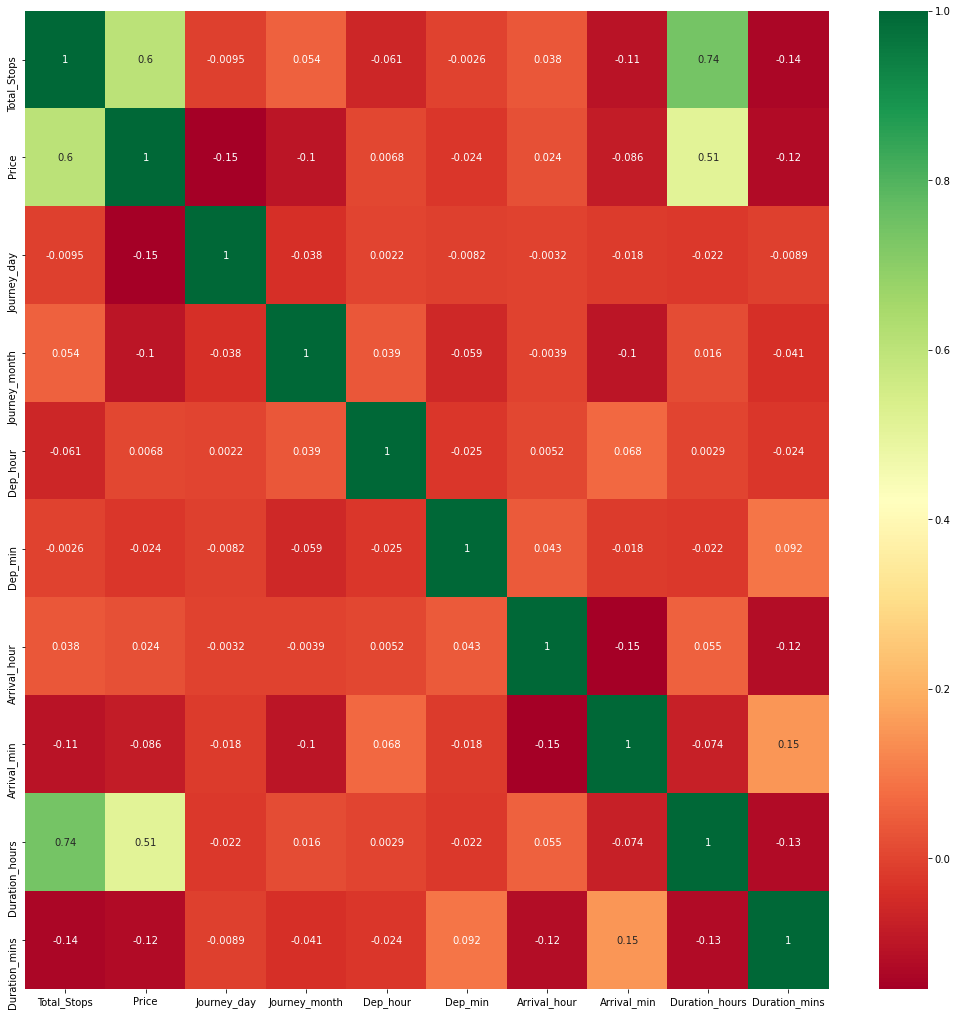

In [176]:
# Finds correlation between Independent and dependent attributes
plt.figure(figsize=(18,18))
sns.heatmap(train_data.corr(), annot=True, cmap='RdYlGn')

In [177]:
# Importance of features
from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X,y)
selection.feature_importances_

ExtraTreesRegressor()

array([2.36769537e-01, 1.44364303e-01, 5.29868229e-02, 2.44881966e-02,
       2.10112110e-02, 2.76157877e-02, 1.91635315e-02, 1.10724783e-01,
       1.78684398e-02, 9.30898620e-03, 1.93895481e-03, 1.94398130e-02,
       1.41010920e-01, 6.70847379e-02, 1.79171655e-02, 8.29819152e-04,
       3.22244629e-03, 9.84567822e-05, 5.16151256e-03, 8.95784918e-05,
       4.33627642e-04, 5.95130487e-03, 8.39065562e-03, 1.87264822e-03,
       4.34127032e-04, 7.87706411e-03, 6.83692094e-03, 9.04974298e-03,
       6.05955769e-03, 5.41468525e-03, 1.57485812e-03, 3.00425418e-04,
       2.47093788e-02])

<Figure size 720x360 with 0 Axes>

<AxesSubplot:>

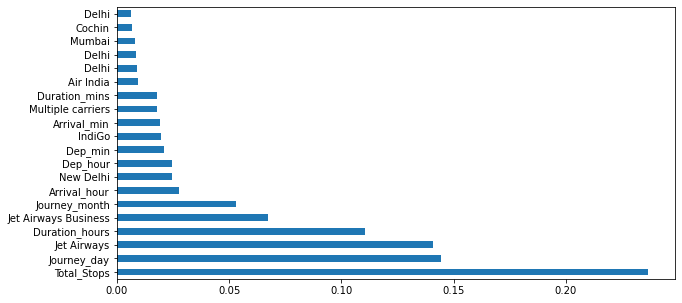

In [181]:
#plot graph of feature importances for better visualization
plt.figure(figsize=(10,5))
pd.Series(selection.feature_importances_,index=X.columns).nlargest(20).plot(kind='barh')


In [182]:
X.shape

(10682, 33)

## Fitting Model using Random Forest

1. Split dataset into train and test set in order to prediction w.r.t X_test
2. If needed do scaling of data
    * Scaling is not done in Random forest
3. Import model
4. Fit the data
5. Predict w.r.t X_test
6. In regression check **RSME** Score
7. Plot graph

In [185]:
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [187]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train,y_train)

y_pred1 = reg_rf.predict(X_test)


RandomForestRegressor()

In [188]:
reg_rf.score(X_train,y_train)
reg_rf.score(X_test,y_test)

0.9535127169170997

0.7980684255291486

C:\Users\Admin\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Price', ylabel='Density'>

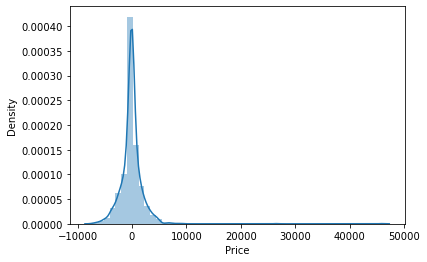

In [189]:
sns.distplot(y_test - y_pred1)

Text(0.5, 0, 'y test')

Text(0, 0.5, 'y predicted')

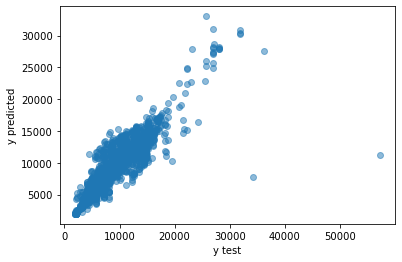

In [191]:
plt.scatter(y_test, y_pred1,alpha=0.5); plt.xlabel('y test');plt.ylabel("y predicted")

In [197]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("RMSE ", mean_squared_error(y_test, y_pred1,squared=False))
print("MSE ", mean_squared_error(y_test, y_pred1))
print("MAE ", mean_absolute_error(y_test, y_pred1))

RMSE  2086.6384407383966
MSE  4354059.982367167
MAE  1173.8839730912641


In [196]:
# RMSE/(max(DV)-min(DV))
(max(y)-min(y))
2090.5509/(max(y)-min(y))

77753

0.026887077025966846

In [198]:
print('Rsqr',r2_score(y_test, y_pred1))

Rsqr 0.7980684255291486


## Hyper parameter tuning


* Choose following method for hyperparameter tuning
    1. **RandomizedSearchCV** --> Fast
    2. **GridSearchCV**
* Assign hyperparameters in form of dictionery
* Fit the model
* Check best paramters and best score

In [199]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [202]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator=reg_rf, param_distributions=random_grid, scoring='neg_mean_squared_error',n_iter=100, cv=10, random_state=42,verbose=2, n_jobs=-1)

rf_random.fit(X_train,y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [204]:
rf_random.best_params_
rf_random.best_score_
rf_random.best_index_
rf_random.best_estimator_

{'n_estimators': 400,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 15}

-3685060.1883039027

46

RandomForestRegressor(max_depth=15, min_samples_split=15, n_estimators=400)

In [205]:
y_pred2 = rf_random.predict(X_test)


C:\Users\Admin\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Price', ylabel='Density'>

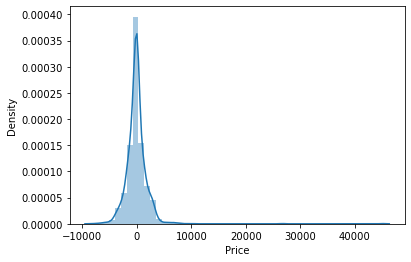

In [206]:
sns.distplot(y_test - y_pred2)

<Figure size 576x576 with 0 Axes>

Text(0.5, 0, 'y_test')

Text(0, 0.5, 'y_pred')

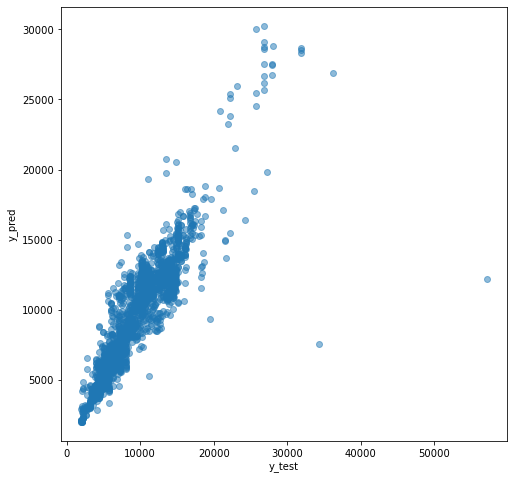

In [208]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, y_pred2, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [209]:
print ("ACCURACIES AFTER HYPERPARAMETER TUNING using Random search cv")
print("RMSE ", mean_squared_error(y_test, y_pred2,squared=False))
print("MSE ", mean_squared_error(y_test, y_pred2))
print("MAE ", mean_absolute_error(y_test, y_pred2))
print('Rsqr',r2_score(y_test, y_pred2))
print()

print("FOR base model accuracies")
print("RMSE ", mean_squared_error(y_test, y_pred1,squared=False))
print("MSE ", mean_squared_error(y_test, y_pred1))
print("MAE ", mean_absolute_error(y_test, y_pred1))
print('Rsqr',r2_score(y_test, y_pred1))

# accuracy increased frm 79.8% to 81.4%

ACCURACIES AFTER HYPERPARAMETER TUNING using Random search cv
RMSE  2003.945367440529
MSE  4015797.0356863565
MAE  1169.3383712602429
Rsqr 0.8137563052747258

FOR base model accuracies
RMSE  2086.6384407383966
MSE  4354059.982367167
MAE  1173.8839730912641
Rsqr 0.7980684255291486


In [210]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=15, min_samples_split=15, n_estimators=400)

In [214]:
best_model = rf_random.best_estimator_
best_model.fit(X_train,y_train)

y_pred_best = best_model.predict(X_test)

print("RMSE ", mean_squared_error(y_test, y_pred_best,squared=False))
print("MSE ", mean_squared_error(y_test, y_pred_best))
print("MAE ", mean_absolute_error(y_test, y_pred_best))
print('Rsqr',r2_score(y_test, y_pred_best))

RandomForestRegressor(max_depth=15, min_samples_split=15, n_estimators=400)

RMSE  2009.2734807852826
MSE  4037179.920587005
MAE  1170.8775371946513
Rsqr 0.812764614845057


C:\Users\Admin\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Price', ylabel='Density'>

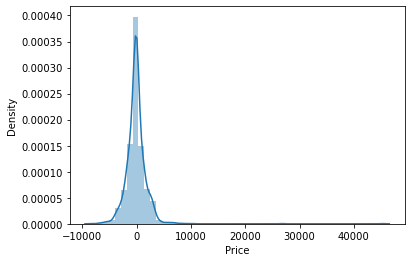

In [215]:
sns.distplot(y_test - y_pred_best)

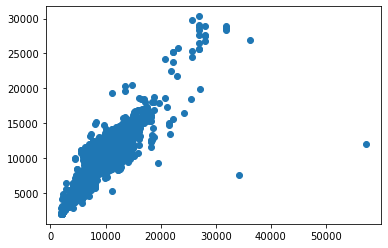

In [216]:
plt.scatter(y_test, y_pred_best)

## Grid Search CV

In [222]:
# Grid search cv
n_estimators = [350,400,450]
nax_depth = [14,15,16]
min_samples_split=[13,15,17]
min_samples_leaf = [1]
max_features = ['auto']

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [350, 400, 450], 'max_features': ['auto'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [13, 15, 17], 'min_samples_leaf': [1]}


In [224]:
reg_rf
rf_grid = RandomizedSearchCV(estimator=reg_rf, param_distributions=random_grid, scoring='neg_mean_squared_error',n_iter=10,cv=5,random_state=42,verbose=2,n_jobs=1)
rf_grid.fit(X_train,y_train)

RandomForestRegressor()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=13, n_estimators=400; total time=   6.7s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=13, n_estimators=400; total time=   6.7s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=13, n_estimators=400; total time=   6.6s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=13, n_estimators=400; total time=   6.5s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=13, n_estimators=400; total time=   6.4s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=400; total time=   6.6s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=400; total time=   6.5s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estima

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [1],
                                        'min_samples_split': [13, 15, 17],
                                        'n_estimators': [350, 400, 450]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [226]:
y_pred_grid = rf_grid.predict(X_test)

print("RMSE ", mean_squared_error(y_test, y_pred_grid,squared=False))
print("MSE ", mean_squared_error(y_test, y_pred_grid))
print("MAE ", mean_absolute_error(y_test, y_pred_grid))
print('Rsqr',r2_score(y_test, y_pred_best))

RMSE  2009.1312123507792
MSE  4036608.228442112
MAE  1164.740806018078
Rsqr 0.812764614845057


In [225]:
rf_grid.best_params_
rf_grid.best_estimator_

{'n_estimators': 450,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

RandomForestRegressor(max_depth=20, min_samples_split=15, n_estimators=450)

In [227]:
rf_random.best_params_
rf_random.best_estimator_

{'n_estimators': 400,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 15}

RandomForestRegressor(max_depth=15, min_samples_split=15, n_estimators=400)

In [228]:
new_best_model = rf_grid.best_estimator_
new_best_model.fit(X_train,y_train)

y_pred_best_new = new_best_model.predict(X_test)

print("RMSE ", mean_squared_error(y_test, y_pred_best_new,squared=False))
print("MSE ", mean_squared_error(y_test, y_pred_best_new))
print("MAE ", mean_absolute_error(y_test, y_pred_best_new))
print('Rsqr',r2_score(y_test, y_pred_best_new))

RandomForestRegressor(max_depth=20, min_samples_split=15, n_estimators=450)

RMSE  2010.383814204127
MSE  4041643.0804139343
MAE  1161.2353127753006
Rsqr 0.812557623463538


### best_model has best accuracy. obtained from random seacrh cv  
so will save model rf_random

## Save the model to reuse it again

In [229]:
import pickle
# open a file, where you want to store the data
file = open("flight_predict_rf.pkl",'wb')

# dump information to that file
pickle.dump(rf_random,file)

In [230]:
model = open('flight_predict_rf.pkl','rb')
rf_new = pickle.load(model)

In [231]:
y_pred_new = rf_new.predict(X_test)
r2_score(y_test, y_pred_new)

0.812764614845057